<a href="https://colab.research.google.com/github/Abhishek-Verma7887/Advanced-Machine-Learning-Specialization/blob/master/Deep%20Learning%20in%20Computer%20Vision/Week4/face-recognition-task/Face%20Recognition%20task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Face recognition using neural network features

In this task, you have to construct face recognizer based on features extracted from the neural network. The task consists of two parts: image classification and video classification. In the first one you should classify distinct images and in the second one you will deal with short video sequences.

In [1]:
!wget "https://d3c33hcgiwev3.cloudfront.net/blRYxTKUEeiISxJZ7npQ3g_6eb16bf0329411e8905a51c51e77c61e_face-recognition-task.zip?Expires=1595376000&Signature=LhGGfS-V8zJ4YTtCefb2nSYno0qowOAtvLfTn1JT9KFxbiYRItqVxIwU2nE9Kc99YJysAaRZOZD3~BkaaJ4f9bayaSVEWotH~Y3F2DOTPQmS1sPegLQtjHjDjGbXg0O-HUPQW4ynXqyEty6kB7WaRQ1~Hhihxu4qW4qmv~6e6Mo_&Key-Pair-Id=APKAJLTNE6QMUY6HBC5A"

The name is too long, 316 chars total.
Trying to shorten...
New name is blRYxTKUEeiISxJZ7npQ3g_6eb16bf0329411e8905a51c51e77c61e_face-recognition-task.zip?Expires=1595376000&Signature=LhGGfS-V8zJ4YTtCefb2nSYno0qowOAtvLfTn1JT9KFxbiYRItqVxIwU2nE9Kc99YJysAaRZOZD3~BkaaJ4f9bayaSVEWotH~Y3F2DOTPQmS1sPegLQtjHjDjGbXg.
--2020-07-20 10:26:53--  https://d3c33hcgiwev3.cloudfront.net/blRYxTKUEeiISxJZ7npQ3g_6eb16bf0329411e8905a51c51e77c61e_face-recognition-task.zip?Expires=1595376000&Signature=LhGGfS-V8zJ4YTtCefb2nSYno0qowOAtvLfTn1JT9KFxbiYRItqVxIwU2nE9Kc99YJysAaRZOZD3~BkaaJ4f9bayaSVEWotH~Y3F2DOTPQmS1sPegLQtjHjDjGbXg0O-HUPQW4ynXqyEty6kB7WaRQ1~Hhihxu4qW4qmv~6e6Mo_&Key-Pair-Id=APKAJLTNE6QMUY6HBC5A
Resolving d3c33hcgiwev3.cloudfront.net (d3c33hcgiwev3.cloudfront.net)... 13.249.10.125, 13.249.10.219, 13.249.10.195, ...
Connecting to d3c33hcgiwev3.cloudfront.net (d3c33hcgiwev3.cloudfront.net)|13.249.10.125|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1021224017 (974M) [applicat

In [2]:
!unzip abc.zip

Archive:  abc.zip
   creating: face-recognition-task/
  inflating: face-recognition-task/get_data.py  
  inflating: face-recognition-task/face_recognition_model.h5  
 extracting: face-recognition-task/Face_Recognition_data.zip  
  inflating: face-recognition-task/Face Recognition task.ipynb  


In [3]:
from keras.models import Model, Sequential
from keras.layers import Flatten, Dense, Activation
from keras.layers import Convolution2D, MaxPooling2D
from keras import backend as K

Using TensorFlow backend.


In [4]:
%pylab inline
from matplotlib import pyplot as plt
import numpy as np
import cv2
import os
from copy import copy
from collections import Counter

Populating the interactive namespace from numpy and matplotlib


First of all, you have you have to read the data. Run the cell below to unpack data.

In [6]:
from get_data import unpack
unpack('/content/abcd/Face_Recognition_data.zip')

### Reading data for image and video classification (1 point)

Implement function $\tt{load}$\_$\tt{image}$\_$\tt{data}$. It should return a tuple of 4 dictionaries: the first two are training images and labels, the second two are testing ones. The keys of the dictionaries are the names of the image files and the values are 3-dimensional numpy arrays (for images) or strings with the names (for labels).

$\tt{dir}$\_$\tt{name}$ is the name of directory with data for image classification. If 'Face_Recofnition_data' directory is located in the same directory as this notebook, then the default value can be used.

In [7]:
import os
from os.path import join
import pandas as pd
from skimage.io import imread
def load_image_data(dir_name = 'Face_Recognition_data/image_classification'):
    """Your implementation"""
    x_train, y_train, x_test, y_test = {}, {}, {}, {}
    for filename in os.listdir(join(dir_name, 'train', 'images')):
        img = imread(join(dir_name, 'train', 'images', filename))
        if len(img.shape) == 2:
            img = gray2rgb(img)
        x_train[filename] = img
    df_train = pd.read_csv(join(dir_name, 'train', 'y_train.csv'))
    for filename, class_id in zip(df_train['filename'], df_train['class_id']):
        y_train[filename] = class_id
        
    for filename in os.listdir(join(dir_name, 'test', 'images')):
        img = imread(join(dir_name, 'test', 'images', filename))
        if len(img.shape) == 2:
            img = gray2rgb(img)
        x_test[filename] = img
    df_test = pd.read_csv(join(dir_name, 'test', 'y_test.csv'))
    for filename, class_id in zip(df_test['filename'], df_test['class_id']):
        y_test[filename] = class_id
    return x_train, y_train, x_test, y_test

In [8]:
x_train, y_train, x_test, y_test = load_image_data()
print(len(x_train), '\ttraining images')
print(len(x_test), '\ttesting images')

661 	training images
808 	testing images


In [9]:
def visualize(data, labels, function = lambda x:x[0], n_cols = 5, n_rows=1):
    figure(figsize = (3*n_cols,3*n_rows))
    for n,i in enumerate(np.random.choice(list(data.keys()), size = n_cols*n_rows)):
        plt.subplot(n_rows,n_cols,n+1)
        plt.axis('off')
        plt.imshow(function([data[i]]))
        plt.title(labels[i])
    plt.show()

That is how the data looks like.

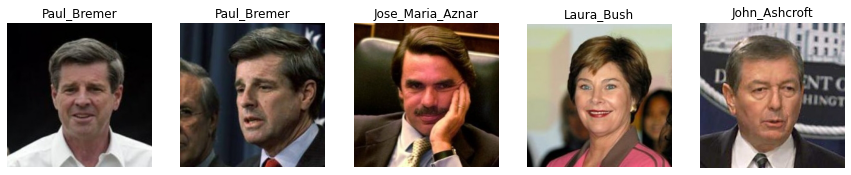

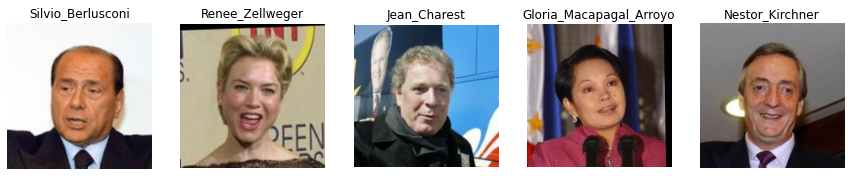

In [10]:
visualize(x_train, y_train)
visualize(x_test, y_test)

Let us now read the video classification data, as well. You have to implement function to load video data.

Function $\tt{load}$\_$\tt{video}$\_$\tt{data}$ should also return a tuple of 4 dictionaries: the first two are training images and labels, the second two are testing videos and labels. The training data is in the same format as in image classification task. The keys of testing data and labels are video ids and the values are the lists of frames and the strings with names, respectively.

In [11]:
def load_video_data(dir_name = 'Face_Recognition_data/video_classification'):
    """Your implementation"""
    video_train, train_labels, video_test, test_labels = {}, {}, {}, {}
    for filename in os.listdir(join(dir_name, 'train', 'images')):
        img = imread(join(dir_name, 'train', 'images', filename))
        if len(img.shape) == 2:
            img = gray2rgb(img)
        video_train[filename] = img
    df_train = pd.read_csv(join(dir_name, 'train', 'y_train.csv'))
    for filename, class_id in zip(df_train['filename'], df_train['class_id']):
        train_labels[filename] = class_id
        
    for video in os.listdir(join(dir_name, 'test', 'videos')):
        video_test[video] = []
        for filename in os.listdir(join(dir_name, 'test', 'videos', video)):
            img = imread(join(dir_name, 'test', 'videos', video, filename))
            if len(img.shape) == 2:
                img = gray2rgb(img)
            video_test[video].append(img)
    df_test = pd.read_csv(join(dir_name, 'test', 'y_test.csv'))
    for filename, class_id in zip(df_test['filename'], df_test['class_id']):
        test_labels[str(filename)] = class_id
    return video_train, train_labels, video_test, test_labels

In [12]:
video_train, train_labels, video_test, test_labels = load_video_data()
print(len(video_train), '\ttraining images')
print(len(video_test), '\ttesting videos')

729 	training images
70 	testing videos


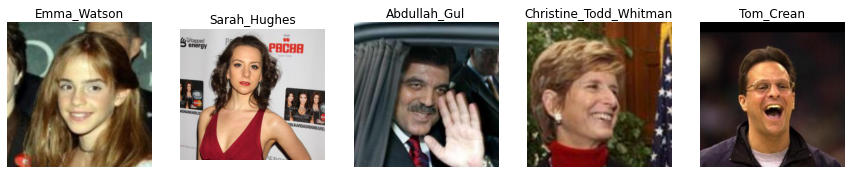

In [13]:
visualize(video_train, train_labels)

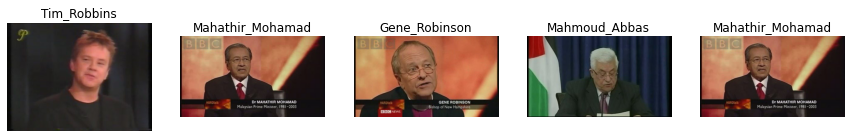

In [14]:
visualize({i:video_test[i][1] for i in video_test}, test_labels)

### Preprocessing (3 points)
You have to implement preprocessing function in the cell below.
Getting a list of images as an input the this function should detect the face on each image, find the facial keypoints () and then crop and normalize the image according to these keypoints. The output of this function is the list of images which contain only the aligned face and should be converted to the tensor of the shape $(N, 224, 224, 3)\ $ where $N$ is the length of the initial list. You can add extra arguments to the preprocess function if necessary (i.e. flag $\tt{is}$\_$\tt{video}$ to determine if the list of images is video sequence or not).

For face detection and facial keypoint regression you can use your models from the previous tasks.

In [15]:
import dlib
from cv2 import resize
detector = dlib.get_frontal_face_detector()
def preprocess_imgs(imgs):
    """Your implementation"""    
    res = []   
    for img in imgs:
        dets = detector(img)
        if len(dets) == 0:
            cropped = resize(img, (224, 224))
            res.append(cropped)
            continue
        for d in dets:
            top = d.top()
            bottom = d.bottom()
            left = d.left()
            right = d.right()
            height = bottom - top
            width = right - left
            # Original dlib face detector has small face area, enlarge it to achieve better
            # performance combined with follwing neural network.
            scale = 0.2
            top = max(0, int(top - height*scale))
            bottom = min(img.shape[0], int(bottom + height*scale))
            left = max(0, int(left - width*scale))
            right = min(img.shape[1], int(right + width*scale))
            if top >= 0 and left >= 0:
                cropped = img[top:bottom, left:right, :]
                cropped = cv2.resize(cropped, (224, 224))
                res.append(cropped)
                break
    if len(res) == 0:
        imshow(imgs[0])
    return res

#### Visualization of preprocessing

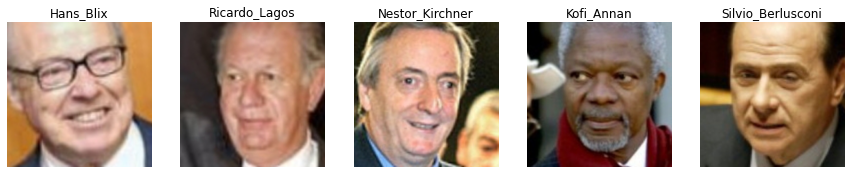

In [16]:
visualize(x_train, y_train, function = lambda x:preprocess_imgs(x)[0])

The neural network is already trained on the other face dataset. You should use this network as feature extractor to get descriptors of the faces. You can choose any hidden layer you need (or several layers) to extract features and any classification method.

In [17]:
import h5py
from keras.models import load_model
model = load_model('/content/abcd/face_recognition_model.h5')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0         
_________________________________________________________________
conv3_1 (Conv2D)             (None, 56, 56, 256)      

Here is an example of using the network as feature extractor. The shape of input tensor has to be (n_images, 224, 224, 3), so you can input several images simultaneously and get their face descriptors of shape (n_images, n_components).

In [18]:
def get_layer_output(images, layer = 'fc6'):
    assert len(images.shape)==4, 'Wrong input dimentionality!'
    assert images.shape[1:]==(224,224,3), 'Wrong input shape!'
    
    network_output = model.get_layer(layer).output
    feature_extraction_model = Model(model.input, network_output)
    
    output = feature_extraction_model.predict(images)
    return output

In [19]:
img = cv2.resize(x_train['0.jpg'], (224,224)).reshape(1,224,224,3)
out = get_layer_output(img)
print(out.shape)

(1, 4096)


### Training classifier (2 points)


You have to implement class $\tt{Classifier}$ with methods $\tt{fit}$, $\tt{classify}$\_$\tt{images}$ and $\tt{classify}$\_$\tt{videos}$ in the cell below. 
The method $\tt{Classifier.fit}$ gets two dictionaries as input: train images and labels, and trains the classifier to predict the person shown on the image.
$\tt{Classifier.classify}$\_$\tt{images}$ gets the dictionary of test images (with filenames as keys) as input and should return the dictionary of the predicted labels.
$\tt{Classifier.classify}$\_$\tt{videos}$ is similar to the previous one, but gets the dictionary of test videos (with video as keys) as input.

To classify video you can combine the predictions for its frames any way you want (averaging, voting, etc.).
If video classification takes too long you can use face detector not in all the frames but every few frames while preprocessing video frames. 
Besides, sometimes the face is hardly detected on the image and the frame in which the detector works wrong can add noise to the prediction. Hence, the result of the prediction without using such frames may be better.

In [96]:
from sklearn.neighbors import KNeighborsClassifier as kNN
from skimage.io import imread
import cv2
from os.path import join
from collections import Counter
class Classifier():
    def __init__(self, nn_model, layer='fc7'):
        """Your implementation"""
        network_output = nn_model.get_layer(layer).output
        self.feature_extraction_model = Model(nn_model.input, network_output)
        self.clf = kNN(n_neighbors=5, weights='distance')
 
 
    def fit(self, train_imgs, train_labels):
        """Your implementation"""
        train_X = []
        train_y = []
        for k, v in train_imgs.items():
            pre_img = preprocess_imgs([v])[0]
            pre_img = pre_img[np.newaxis, ...]
            train_X_features = self.feature_extraction_model.predict(pre_img)
            train_X.append(train_X_features)
            train_y.append(train_labels[k])
            
        train_X = np.asarray(train_X)
        train_X = np.reshape(train_X, (-1, 4096))
        train_y = np.asarray(train_y)
        self.clf.fit(train_X,train_y)
 
 
    def classify_images(self, test_imgs):
        """Your implementation"""
        res = {}
        for k, v in test_imgs.items():
            pre_img = preprocess_imgs([v])[0]
            print(pre_img.shape)
            pre_img = pre_img[np.newaxis, ...]
            print(pre_img.shape)
            test_img_features = self.feature_extraction_model.predict(pre_img)
            predicted_y = self.clf.predict(test_img_features)[0]
            res[k] = predicted_y
       
        return res
       
    def classify_myimg(self,my_img):
        pre_img = preprocess_imgs([my_img])[0]  
        #print(pre_img.shape)  
        pre_img = pre_img[np.newaxis , ...]
        test_img_features = self.feature_extraction_model.predict(pre_img)
        predicted_y = self.clf.predict(test_img_features)[0]
        return predicted_y
    
    def classify_videos(self, test_video):
        """Your implementation"""
        res = {}
        for k, v in test_video.items():
            table = Counter()
            for img in v:
                pre_img = preprocess_imgs([img])[0]
                pre_img = pre_img[np.newaxis, ...]
                test_img_features = self.feature_extraction_model.predict(pre_img)
                predicted_y = self.clf.predict(test_img_features)[0]
                table[predicted_y] += 1
            res[k] = max(table, key=lambda x:table[x])
 
        return res

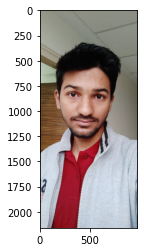

In [104]:
my_img=imread("/content/Abhi.jpg")
plt.imshow(my_img)

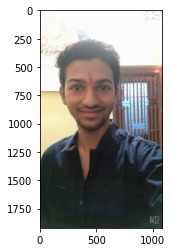

In [103]:
 my2_img=imread("/content/Popi.jpg")
plt.imshow(my_img)

In [97]:
my_img.shape

(2160, 972, 3)

In [78]:
type(my_img)

numpy.ndarray

In [94]:
pre_img = preprocess_imgs([my_img])[0]  
type(pre_img)
print(pre_img.shape)

(224, 224, 3)


In [98]:
x_train["abhishek_verma"]=my_img
y_train["abhishek_verma"]="abhishek_verma"

Now we can build the classifier, fit it and use to predict the labels of testing images.

In [99]:
img_classifier = Classifier(model)
img_classifier.fit(x_train, y_train)

In [90]:
img_classifier = Classifier(model)

In [105]:
new_y=img_classifier.classify_myimg(my2_img)

In [106]:
print(new_y)

James_Blake


In [91]:
y_out = img_classifier.classify_images(x_test)

(224, 224, 3)
(1, 224, 224, 3)


NotFittedError: ignored

### Image classification quality (2 points)

Let us check the accuracy of your classification. To obtain 1 point for that rubric your implementation must have accuracy at least 0.90, to obtain 2 points — at least 0.95.

In [ ]:
def check_test(output, gt):
    correct = 0.
    total = len(gt)
    for k, v in gt.items():
        if output[k] == v:
            correct += 1
    accuracy = correct / total

    return 'Classification accuracy is %.4f' % accuracy

In [ ]:
print(check_test(y_out, y_test))

Classification accuracy is 0.9604


### Video classification quality (2 points)

Let us check the quality of video classification. To obtain 1 point for that rubric your implementation must have accuracy at least 0.80, to obtain 2 points — at least 0.85.

In [ ]:
video_classifier = Classifier(model)
video_classifier.fit(video_train, train_labels)

In [ ]:
y_video_out = video_classifier.classify_videos(video_test)

In [ ]:
print(check_test(y_video_out, test_labels))

Classification accuracy is 0.8571
